In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/measurements_10km_la.csv")

print(df.shape)

df.head()

(368614, 12)


,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm


In [40]:
# Split epoch into date and time columns
df['year'] = pd.to_datetime(df['epoch']).dt.year
df['date'] = pd.to_datetime(df['epoch']).dt.date
df['time'] = pd.to_datetime(df['epoch']).dt.time

df.head()

,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units,year,date,time
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm,2016,2016-11-15,20:00:00
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm,2016,2016-11-16,00:00:00
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm,2016,2016-11-16,01:00:00
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm,2016,2016-11-16,02:00:00
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm,2016,2016-11-16,03:00:00


In [41]:
# keep only rows where the units are ppm
df = df[df['units'] == 'ppm']

print(df.shape)

df.head()

(19000, 15)


,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units,year,date,time
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,0.71,ppm,2016,2016-11-15,20:00:00
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,0.55,ppm,2016,2016-11-16,00:00:00
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,0.57,ppm,2016,2016-11-16,01:00:00
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,0.54,ppm,2016,2016-11-16,02:00:00
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,0.43,ppm,2016,2016-11-16,03:00:00


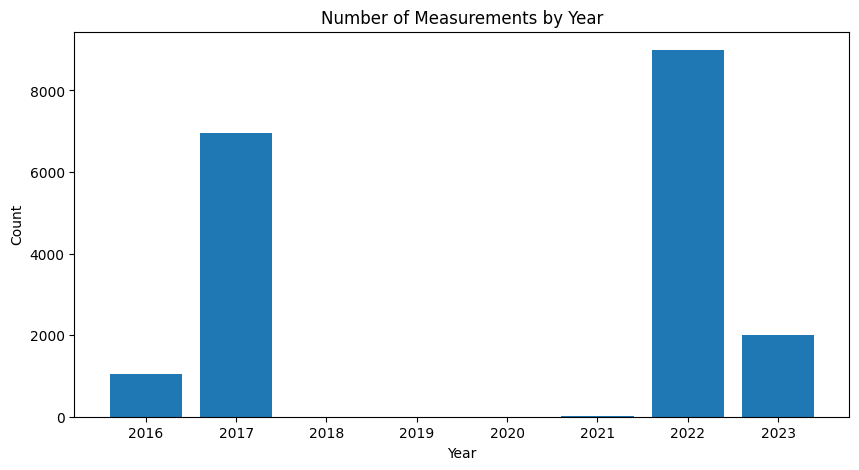

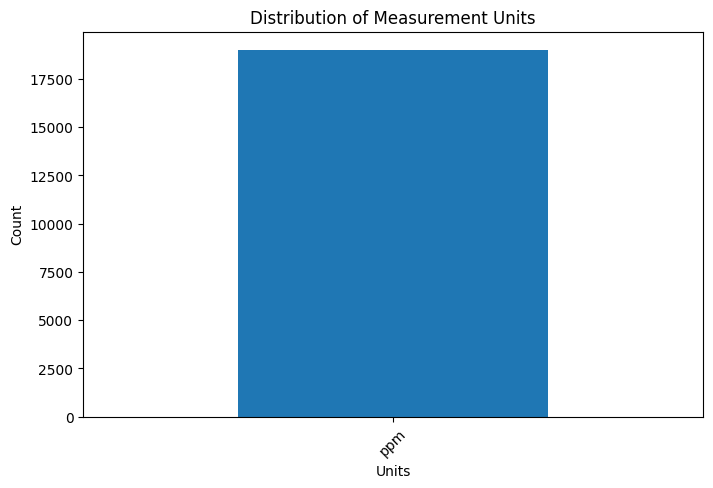

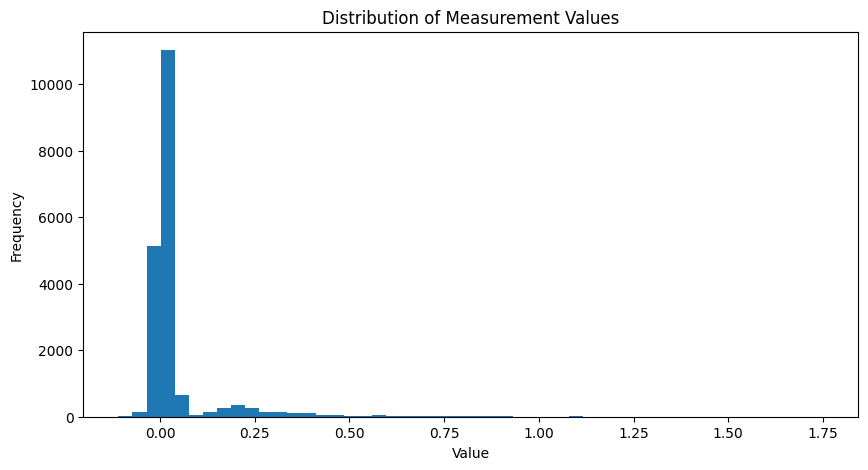

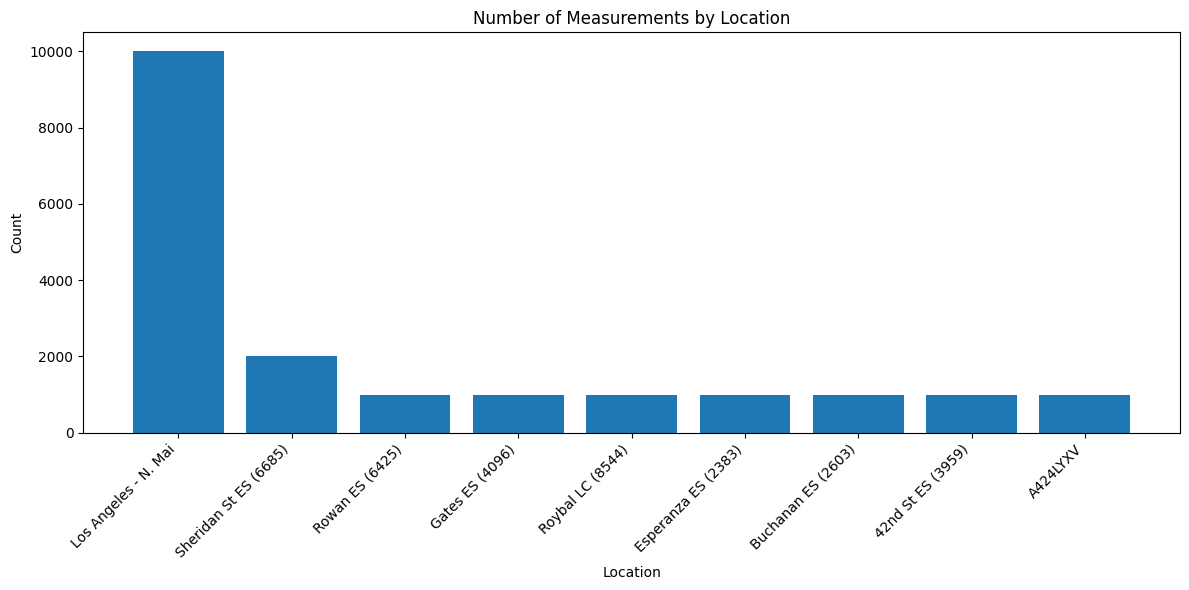

unique_id         0
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
year              0
date              0
time              0
dtype: int64

In [42]:
# Count measurements per year
year_counts = df['year'].value_counts().sort_index()

# Plot measurements per year
plt.figure(figsize=(10,5))
plt.bar(year_counts.index, year_counts.values)
plt.title('Number of Measurements by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Plot histogram of units
plt.figure(figsize=(8,5))
df['units'].value_counts().plot(kind='bar')
plt.title('Distribution of Measurement Units')
plt.xlabel('Units')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plot histogram of values
plt.figure(figsize=(10,5))
plt.hist(df['value'], bins=50)
plt.title('Distribution of Measurement Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Count measurements per location
location_counts = df['location'].value_counts()

# Plot measurements per location
plt.figure(figsize=(12,6))
plt.bar(range(len(location_counts)), location_counts.values)
plt.title('Number of Measurements by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(range(len(location_counts)), location_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()


df.isna().sum()


In [43]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

df['epoch'] = pd.to_datetime(df['epoch'])

def compute_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km


def get_3_closest_sensors(target_row, df, Y=24, X=10):
    """
    Given a single row (the 'target'), find up to 3 sensor readings
    that:
      1) Have 'epoch' < target_row['epoch'] (only past data),
      2) Are within [target_epoch - Y hours, target_epoch),
      3) Are within X km of (target_lat, target_lon).

    Return a dict with:
      - location1_distance, location1_reading, location1_time_elapsed
      - location2_distance, location2_reading, location2_time_elapsed
      - location3_distance, location3_reading, location3_time_elapsed

    If fewer than 3 exist, fill the missing ones with NaN.
    """

    # Unpack the target's data
    target_lat = target_row['latitude']
    target_lon = target_row['longitude']
    target_time = target_row['epoch']

    # Window of time: only look at sensor readings in [target_time - Y, target_time)
    start_time = target_time - pd.Timedelta(hours=Y)

    # Filter df for rows BEFORE the target's epoch (so we don't see the future)
    # and within Y hours of target_time.
    mask_time = (df['epoch'] >= start_time) & (df['epoch'] < target_time)
    df_time_filtered = df[mask_time]

    if df_time_filtered.empty:
        # No rows in that time window
        return _empty_top3_dict()

    # Compute distances to the target location
    # We'll do it on the filtered rows only
    temp_df = df_time_filtered.copy()
    temp_df['distance'] = temp_df.apply(
        lambda r: compute_distance(r['latitude'], r['longitude'],
                                   target_lat, target_lon),
        axis=1
    )

    # Filter to only those within X km
    temp_df = temp_df[temp_df['distance'] <= X]
    
    # Exclude the target row itself if it's in the dataset
    # (in case sensor_id or unique_id overlaps).
    # We usually don't want to use the same sensor reading as the "predictor"
    # for itself. So let's exclude identical row if that can appear:
    same_row_mask = (temp_df['unique_id'] == target_row['unique_id'])
    temp_df = temp_df[~same_row_mask]

    if temp_df.empty:
        # No sensors within distance/time criteria
        return _empty_top3_dict()

    # We may have multiple readings from the same sensor in that time window.
    # Decide how to aggregate them. For example:
    #   - use the LATEST reading from that sensor
    #   - or average them
    # Here, let's pick the "latest" reading from each sensor:
    # So we group by sensor_id, pick the row with the max epoch.
    # Then from those, we'll pick the 3 nearest sensors by 'distance'.
    temp_df.sort_values(['sensor_id', 'epoch'], ascending=[True, False], inplace=True)
    temp_df = temp_df.drop_duplicates(subset=['sensor_id'], keep='first')
    
    # Now we sort by distance ascending and pick top 3
    temp_df.sort_values('distance', ascending=True, inplace=True)
    top3_df = temp_df.head(3)

    # Build the output
    return _build_top3_dict(top3_df, target_time)


def _empty_top3_dict():
    """
    Helper: returns a dictionary with 3 sets of NaN values.
    """
    return {
        'location1_distance': np.nan, 'location1_reading': np.nan, 'location1_time_elapsed': np.nan,
        'location2_distance': np.nan, 'location2_reading': np.nan, 'location2_time_elapsed': np.nan,
        'location3_distance': np.nan, 'location3_reading': np.nan, 'location3_time_elapsed': np.nan
    }

def _build_top3_dict(top3_df, target_time):
    """
    top3_df has up to 3 rows, sorted by ascending distance.
    Build a dictionary: location1_distance, location1_reading, ...
    """
    out = {}
    # For each of the 3 possible sensors:
    for i in range(3):
        if i < len(top3_df):
            row_i = top3_df.iloc[i]
            dist = row_i['distance']
            reading = row_i['value']
            sensor_time = row_i['epoch']
            # time_elapsed: how many hours before target_time
            time_elapsed = (target_time - sensor_time).total_seconds() / 3600.0

            out[f'location{i+1}_distance'] = dist
            out[f'location{i+1}_reading']  = reading
            out[f'location{i+1}_time_elapsed'] = time_elapsed
        else:
            # If we don't have a i-th sensor, fill with NaN
            out[f'location{i+1}_distance'] = np.nan
            out[f'location{i+1}_reading']  = np.nan
            out[f'location{i+1}_time_elapsed'] = np.nan

    return out


# Example usage:
# Suppose X=10 km, Y=24 hours
X = 5
Y = 6

# We'll store these new columns in the DataFrame
results = df.apply(lambda row: get_3_closest_sensors(row, df, Y=Y, X=X), axis=1)

# 'results' is a series of dicts. Convert it to a DataFrame:
results_df = pd.DataFrame(results.tolist())

# results_df now has columns:
# [
#   'location1_distance', 'location1_reading', 'location1_time_elapsed',
#   'location2_distance', 'location2_reading', 'location2_time_elapsed',
#   'location3_distance', 'location3_reading', 'location3_time_elapsed'
# ]

# Concatenate these columns with your original df
df_final = pd.concat([df.reset_index(drop=True), results_df], axis=1)

df_final.head()


,unique_id,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,...,time,location1_distance,location1_reading,location1_time_elapsed,location2_distance,location2_reading,location2_time_elapsed,location3_distance,location3_reading,location3_time_elapsed
0,1575_8681_1,1,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-15 20:00:00,0 days 01:00:00,co,...,20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1575_8681_2,2,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 00:00:00,0 days 01:00:00,co,...,00:00:00,0.0,0.027,4.0,0.0,0.71,4.0,0.0,0.001,4.0
2,1575_8681_3,3,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 01:00:00,0 days 01:00:00,co,...,01:00:00,0.0,0.029,1.0,0.0,0.55,1.0,0.0,0.001,1.0
3,1575_8681_4,4,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 02:00:00,0 days 01:00:00,co,...,02:00:00,0.0,0.019,1.0,0.0,0.57,1.0,0.0,0.001,1.0
4,1575_8681_5,5,8681,1575,Los Angeles - N. Mai,34.0669,-118.2417,2016-11-16 03:00:00,0 days 01:00:00,co,...,03:00:00,0.0,0.016,1.0,0.0,0.54,1.0,0.0,0.001,1.0


In [48]:
print(results_df.shape)
results_df.head()

# dorp any with nan
results_df = results_df.dropna()

print(results_df.shape)
results_df.head()

(19000, 9)
(6622, 9)


,location1_distance,location1_reading,location1_time_elapsed,location2_distance,location2_reading,location2_time_elapsed,location3_distance,location3_reading,location3_time_elapsed
1,0.0,0.027,4.0,0.0,0.71,4.0,0.0,0.001,4.0
2,0.0,0.029,1.0,0.0,0.55,1.0,0.0,0.001,1.0
3,0.0,0.019,1.0,0.0,0.57,1.0,0.0,0.001,1.0
4,0.0,0.016,1.0,0.0,0.54,1.0,0.0,0.001,1.0
5,0.0,0.013,3.0,0.0,0.43,3.0,0.0,0.000,3.0
